<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Test10_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/tdata.zip" .

Mounted at /content/drive


In [ ]:
temp_dir = './temp'
train_dir = temp_dir + "/tdata/train"
test_dir = temp_dir + "/tdata/test"
out_dir = '/content/drive/MyDrive/Colab Notebooks/output'
checkpoint_path = out_dir + "/cp.ckpt"

In [ ]:
import shutil
import os

if os.path.isdir(temp_dir):
  shutil.rmtree(temp_dir)

In [ ]:
import glob
import zipfile
shutil.unpack_archive('tdata.zip', temp_dir)
os.makedirs(test_dir+'/dummy/', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

In [ ]:
import pandas as pd
df = pd.read_csv(temp_dir+"/tdata/train.csv")
test_df = pd.read_csv(temp_dir+"/tdata/sample_submission.csv")

rep = {5:7}
df["gender_status"] = df["gender_status"].replace(rep).astype(int)
display(df)

,image,gender_status
0,n_00001.jpg,4
1,n_00002.jpg,0
2,n_00003.jpg,0
3,n_00005.jpg,0
4,n_00006.jpg,0
...,...,...
4233,n_05293.jpg,1
4234,n_05294.jpg,1
4235,n_05295.jpg,0
4236,n_05296.jpg,0


In [ ]:
from sklearn.model_selection import StratifiedKFold

N_SPLIT = 3

# Storing the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.2
                            )

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, # 255で割ることで正規化
                                   zoom_range=0.2, # ランダムにズーム
                                   horizontal_flip = True, # 水平反転
                                   rotation_range = 20, # ランダムに回転
                                   vertical_flip = False, # 垂直反転
                                   featurewise_center=False,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
df['gender_status'] = df['gender_status'].astype(str)
train_x = df["image"]
train_y = df["gender_status"]

import gc
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import mobilenet

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3
BATCH_SIZE = 50
CATEGORY_NUM = 7

base_model = mobilenet.MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

  # モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# モデルの概要
model.summary()

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

Found 2260 validated image filenames belonging to 7 classes.
Found 282 validated image filenames belonging to 7 classes.
Epoch 1/5
45/45 [==============================] - 42s 932ms/step - loss: 0.3628 - accuracy: 0.8661 - val_loss: 0.7162 - val_accuracy: 0.7720
Epoch 2/5
45/45 [==============================] - 43s 957ms/step - loss: 0.3167 - accuracy: 0.8887 - val_loss: 0.6680 - val_accuracy: 0.7560
Epoch 3/5
45/45 [==============================] - 47s 1s/step - loss: 0.2986 - accuracy: 0.8878 - val_loss: 0.7137 - val_accuracy: 0.7680
Epoch 4/5
45/45 [==============================] - 42s 935ms/step - loss: 0.2646 - accuracy: 0.9100 - val_loss: 0.8034 - val_accuracy: 0.7760
Epoch 5/5
6/6 [==============================] - 5s 808ms/step - loss: 0.8647 - accuracy: 0.7695
test loss: 0.86, test accuracy: 76.95%


<ipython-input-19-9ad8d6c52489>:69: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける


17/17 [==============================] - 4s 206ms/step
Found 2260 validated image filenames belonging to 7 classes.
Found 282 validated image filenames belonging to 7 classes.
Epoch 1/5
45/45 [==============================] - 41s 919ms/step - loss: 0.3240 - accuracy: 0.8846 - val_loss: 0.6402 - val_accuracy: 0.7920
Epoch 2/5
45/45 [==============================] - 43s 957ms/step - loss: 0.2854 - accuracy: 0.8977 - val_loss: 0.6926 - val_accuracy: 0.7960
Epoch 3/5
45/45 [==============================] - 41s 916ms/step - loss: 0.2703 - accuracy: 0.9059 - val_loss: 0.6236 - val_accuracy: 0.8280
Epoch 4/5
45/45 [==============================] - 41s 925ms/step - loss: 0.2337 - accuracy: 0.9149 - val_loss: 0.7849 - val_accuracy: 0.7720
Epoch 5/5
6/6 [==============================] - 5s 898ms/step - loss: 0.7925 - accuracy: 0.7872
test loss: 0.79, test accuracy: 78.72%
17/17 [==============================] - 3s 165ms/step
Found 2261 validated image filenames belonging to 7 classes.
Foun

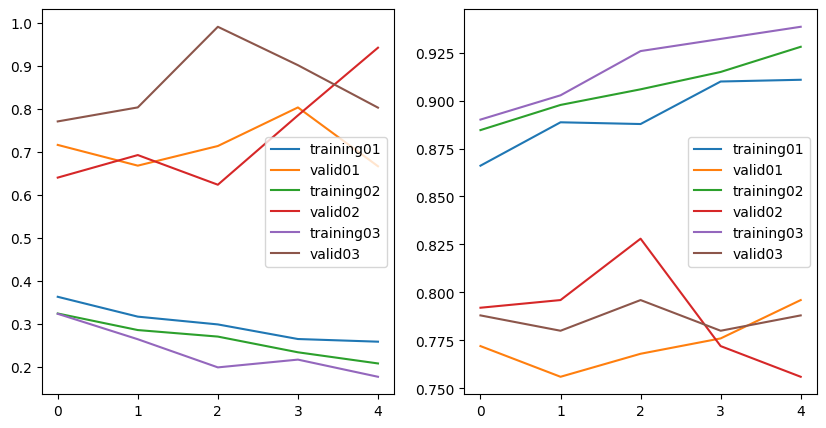

In [ ]:
import matplotlib.pyplot as plt
import os
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
plt.title("metric")

import numpy as np
# Variable for keeping count of split we are executing
j = 0
# K-fold Train and test for each split
for train_idx, val_idx in list(kfold.split(train_x,train_y)):
  '''
  if(j>0):
    # Load the previously saved weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
  '''
  x_train_df = df.iloc[train_idx]
  x_valid_df = df.iloc[val_idx]

  j+=1

  train_generator = train_datagen.flow_from_dataframe(dataframe=x_train_df,
                                                      directory=train_dir,
                                                      x_col="image",
                                                      y_col="gender_status",
                                                      class_mode='categorical',
                                                      target_size=(256,256),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      subset = "training")

  val_generator = train_datagen.flow_from_dataframe(dataframe=x_valid_df,
                                                      directory=train_dir,
                                                      x_col="image",
                                                      y_col="gender_status",
                                                      class_mode='categorical',
                                                      target_size=(256,256),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      subset = "validation")

  # Early stoppingを適用してフィッティング
  log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
                  #           keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)],
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 5,
                  workers = 1
  )

  # 評価する。
  test_loss, test_acc = model.evaluate(val_generator)
  print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
  model_path = os.path.join(out_dir,'/cnn_mobile_'+str(j).zfill(2)+'.keras')
  model.save(model_path)

  for i in range(len(metrics)):

    metric = metrics[i]
    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.plot(plt_train, label='training'+str(j).zfill(2))
    plt.plot(plt_valid, label='valid'+str(j).zfill(2))
    plt.legend()

  prediction = model.predict(test_generator)
  results = np.argmax(prediction,axis=1)
  data_kfold[j] = results
  gc.collect()

plt.savefig("metrics.jpg")

In [ ]:
# holder
data_kfold

,1,2,3
0,1,1,1
1,1,1,1
2,4,4,4
3,4,3,3
4,3,3,3
...,...,...,...
1055,1,1,1
1056,1,1,1
1057,2,2,2
1058,0,0,0


In [ ]:
'''
# testing on single iteration of HoldOut
result = data_kfold[1]
labels=(train_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in result]
'''

In [ ]:
ans = test_df.copy()
ans

,image,gender_status
0,n_00000.jpg,0
1,n_00004.jpg,0
2,n_00009.jpg,0
3,n_00026.jpg,0
4,n_00030.jpg,0
...,...,...
1055,n_05269.jpg,0
1056,n_05278.jpg,0
1057,n_05285.jpg,0
1058,n_05286.jpg,0


In [ ]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '6': 5, '7': 6}

In [ ]:
# Taking The Label with Maximum Occurences
labels=(train_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())

import collections
for i in range(len(data_kfold)):
    co = collections.Counter(data_kfold.loc[i])
    co = sorted(co.items(),key=lambda x: x[1],reverse=True)
    ans['gender_status'].loc[i] = labels2[co[0][0]]

<ipython-input-16-8d255e8aaafb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans['gender_status'].loc[i] = labels2[co[0][0]]


In [ ]:
ans

,image,gender_status
0,n_00000.jpg,1
1,n_00004.jpg,1
2,n_00009.jpg,4
3,n_00026.jpg,3
4,n_00030.jpg,3
...,...,...
1055,n_05269.jpg,1
1056,n_05278.jpg,1
1057,n_05285.jpg,2
1058,n_05286.jpg,0


In [ ]:
  #print(results)
  ans.to_csv(path_or_buf="./out_pred.csv")

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator, val_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=None))

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

swarm_plot = sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

fig = swarm_plot.get_figure()
fig.savefig("out.png")

In [ ]:
#from tensorflow.keras.models import Model, load_model
#model = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')